## DS 5110 Final Project - Hospital Mortality
## Team 3
### By: Elena Tsvetskova, Brian Chae, Ryan Viti (rrv7eb)

In [1]:
# importing necessary libraries and packages
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import round, col, isnan, when, count, countDistinct, mean, floor, asc, desc
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# session initialization
spark = SparkSession.builder \
        .master("local") \
        .appName("Team 3 Final Project") \
        .getOrCreate()

filename = "hospital_mortality.csv"

data = spark.read.csv(filename, inferSchema=True, header=True)
data.count()

91713

In [2]:
# printing original dataset schema
data.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_id: integer (nullable = true)
 |-- hospital_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_id: integer (nullable = true)
 |-- icu_stay_type: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_2_diagnosis: integer (nullable = true)
 |-- apache_3j_diagnosis: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- gcs_verbal_apache

## Data Preprocessing / EDA

In [3]:
data = data.drop("_c83", "patient_id", "encounter_id", "hospital_id", "icu_id", "icu_stay_type") # id columns and column with no information
colsToDrop = [] # keeping a running list of columns to drop for the end of preprocessing

147 unique hospitals and 241 unique ICU's in the dataset, which could provide information about survival.

### Experimenting with NA Origins for Certain Columns

In [4]:
# Quantifying amount of null values in each column of the dataset

naCountsDf = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])
naCountsDf.show()

+----+----+----------------+---------+------+------+----------------+--------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-------------

In [5]:
naCountsNoninvasive = naCountsDf.select(*filter(lambda col: 'noninvasive' in col, naCountsDf.columns))
naCountsNoninvasive.show()

+-------------------------+-------------------------+----------------------+----------------------+------------------------+------------------------+-------------------------+-------------------------+----------------------+----------------------+------------------------+------------------------+
|d1_diasbp_noninvasive_max|d1_diasbp_noninvasive_min|d1_mbp_noninvasive_max|d1_mbp_noninvasive_min|d1_sysbp_noninvasive_max|d1_sysbp_noninvasive_min|h1_diasbp_noninvasive_max|h1_diasbp_noninvasive_min|h1_mbp_noninvasive_max|h1_mbp_noninvasive_min|h1_sysbp_noninvasive_max|h1_sysbp_noninvasive_min|
+-------------------------+-------------------------+----------------------+----------------------+------------------------+------------------------+-------------------------+-------------------------+----------------------+----------------------+------------------------+------------------------+
|                     1040|                     1040|                  1479|                  1479|       

In [6]:
naCountsInvasive = naCountsDf.select([col for col in naCountsDf.columns if (col.startswith(("h1_diasbp","d1_diasbp","h1_mbp", "d1_sysbp","d1_mbp")) and ('noninvasive' not in col))])
naCountsInvasive.show()

+-------------+-------------+----------+----------+------------+------------+-------------+-------------+----------+----------+
|d1_diasbp_max|d1_diasbp_min|d1_mbp_max|d1_mbp_min|d1_sysbp_max|d1_sysbp_min|h1_diasbp_max|h1_diasbp_min|h1_mbp_max|h1_mbp_min|
+-------------+-------------+----------+----------+------------+------------+-------------+-------------+----------+----------+
|          165|          165|       220|       220|         159|         159|         3619|         3619|      4639|      4639|
+-------------+-------------+----------+----------+------------+------------+-------------+-------------+----------+----------+



Dropping noninvasive measurement columns due to their higher frequency of NAs, overall higher accuracy of its invasive counterparts, and potential for high correlations between them.

In [8]:
# dropping noninvasive measurements due to high frequency of NA and lower accuracy of a noninvasive measurement
condition = lambda col: 'noninvasive' in col
data = data.drop(*filter(condition, data.columns))
# amount of columns remaining after dropping
len(data.columns)

67

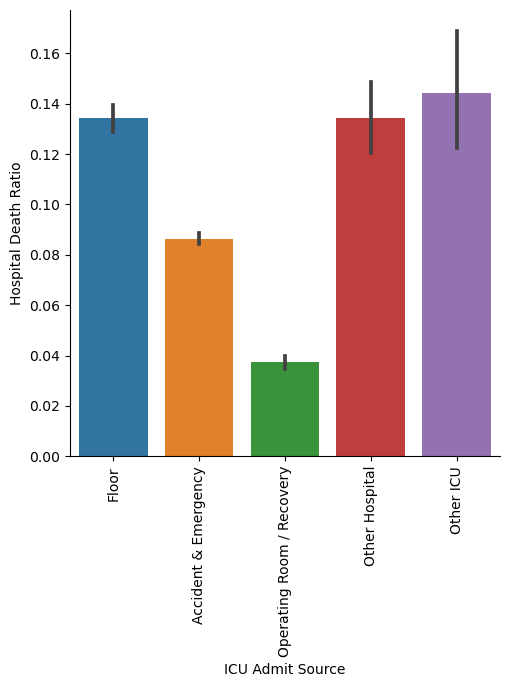

In [9]:
pandas_df = data.toPandas()
sns.catplot(x="icu_admit_source",y="hospital_death",kind="bar",data=pandas_df)
plt.xticks(rotation=90)
plt.xlabel("ICU Admit Source")
plt.ylabel("Hospital Death Ratio")
plt.show()

There are significant differences in death rates per the ICU admit source; this could be a potentially predictive variable.

In [10]:
# continuing null value analysis on our dataset
num_nulls_df = data.withColumn('numNulls', sum(data[col].isNull().cast('int') for col in data.columns))
less_nulls_df = num_nulls_df.filter(col('h1_mbp_min').isNotNull())
x = range(1,11)
y = []
for i in range(1, 11):
    y.append(less_nulls_df.filter(less_nulls_df.numNulls < i).count())

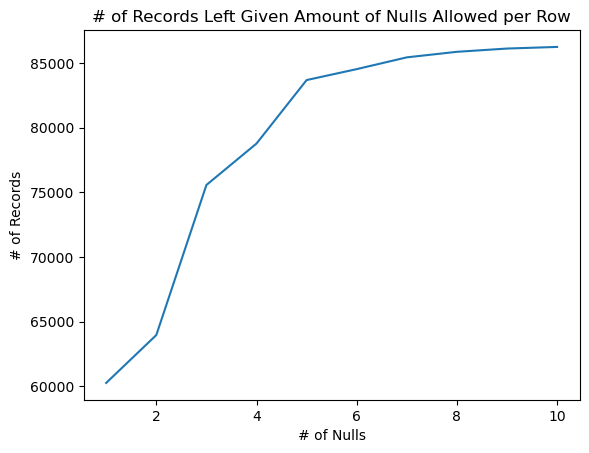

In [11]:
plt.title('# of Records Left Given Amount of Nulls Allowed per Row')
plt.xlabel('# of Nulls')
plt.ylabel('# of Records')
plt.plot(x, y)
plt.show()

In [12]:
# Computing the average number of nulls per row, for reference
num_nulls_column = num_nulls_df.select("numNulls")
filtered = num_nulls_column.filter(col("numNulls")!= 0)
filtered.select(mean(col("numNulls").alias("AVG Nulls/Row"))).show()

+--------------------------------+
|avg(numNulls AS `AVG Nulls/Row`)|
+--------------------------------+
|               4.505564741795981|
+--------------------------------+



#### Using a threshold of 5 nulls per row, due to the apparent elbow in our Records vs. Nulls plot.  Also, this value of nulls is around the average number of nulls present in our most recent working version of the dataset.

In [13]:
less_nulls_df = less_nulls_df.filter(less_nulls_df.numNulls < 5)
# dropping these columns due to having a similar role to our label variable, as well as the high number of NAs per column weighed against the information provided in a healthcare context
colsToDrop.append("apache_4a_hospital_death_prob")
colsToDrop.append("apache_4a_icu_death_prob")
colsToDrop.append("d1_potassium_max")
colsToDrop.append("d1_potassium_min")
colsToDrop.append("numNulls")

In [14]:
df_cleaned = less_nulls_df.drop(*colsToDrop)
df_cleaned.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_2_diagnosis: integer (nullable = true)
 |-- apache_3j_diagnosis: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- gcs_verbal_apache: integer (nullable = true)
 |-- heart_rate_apache: integer (nullable = true)
 |-- intubated_apache: integer (nullable = true)
 |-- map_apache: integer (nullable = true)
 |-- resprate_apache: double (nullable = true)

In [15]:
df_cleaned_numRows = df_cleaned.count()
df_cleaned_numRows

83672

### Decimal Percentage of Columns Containing Nulls

In [16]:
df_NA_check = df_cleaned.select([round((count(when(col(c).isNull(), c))/df_cleaned_numRows),3).alias(c) for c in df_cleaned.columns])
df_NA_check.show()

+-----+----+----------------+---------+------+------+----------------+--------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+----------------+----------------+----------+----------+---------------+---------------+-----------+-----------+------------+------------+-----------+-----------+-------------+-------------+----------------+----------------+----------+----------+---------------+---------------+-----------+-----------+------------+------------+--------------+--------------+----+---------+-----------------+---------------+-----------------+--------+--------+---------------------------+--------------------+-------------------+--------------+
|  age| bmi|elective_surgery|ethnicity|gender|height|icu_admit_source|icu_type|pre_icu_los_days|weight|apach

Single imputation is ill-advised based on multiple research studies when dealing with healthcare data, so we will avoid this and instead, since the ratio of NAs in every column falls below 0.05, will feasibly drop the remaining rows containing null values.

In [17]:
print("Number of patients' records saved via cleaning + EDA: {}".format((df_cleaned.dropna().count()-data.dropna().count())))
df_cleaned = df_cleaned.dropna()
print("Final # of Records in Cleaned Dataset:", df_cleaned.count())

Number of patients' records saved via cleaning + EDA: 8329
Final # of Records in Cleaned Dataset: 68594


## Feature Engineering / Inspection

**ICU Admit Source**

In [18]:
df_cleaned.groupBy("icu_admit_source").count().show()

+--------------------+-----+
|    icu_admit_source|count|
+--------------------+-----+
|Operating Room / ...|14531|
|Accident & Emergency|40170|
|               Floor|11538|
|      Other Hospital| 1901|
|           Other ICU|  454|
+--------------------+-----+



In [19]:
df_cleaned = df_cleaned.withColumn("icu_admit_source", when(df_cleaned.icu_admit_source== "Other Hospital","Other")
                                 .when(df_cleaned.icu_admit_source== "Other ICU","Other")
                                 .when(df_cleaned.icu_admit_source== "Operating/Recovery", "Operating & Recovery")
                                 .otherwise(df_cleaned.icu_admit_source))
df_cleaned.groupBy("icu_admit_source").count().show()

+--------------------+-----+
|    icu_admit_source|count|
+--------------------+-----+
|Operating Room / ...|14531|
|Accident & Emergency|40170|
|               Floor|11538|
|               Other| 2355|
+--------------------+-----+



**APACHE (Acute Physiology, Age, and Chronic Health Evaluation) Diagnosis Codes**

In [20]:
df_cleaned.groupBy("apache_2_diagnosis").count().orderBy(col("count").desc()).show()

+------------------+-----+
|apache_2_diagnosis|count|
+------------------+-----+
|               113| 9378|
|               301| 5000|
|               302| 4733|
|               308| 3314|
|               112| 3222|
|               124| 2939|
|               122| 2750|
|               117| 2718|
|               303| 2585|
|               304| 2383|
|               110| 2377|
|               203| 2182|
|               202| 1991|
|               106| 1807|
|               305| 1726|
|               123| 1692|
|               121| 1689|
|               114| 1657|
|               102| 1500|
|               307| 1444|
+------------------+-----+
only showing top 20 rows



In [21]:
df_cleaned.orderBy(col("apache_3j_diagnosis").asc()).groupBy(floor("apache_3j_diagnosis").alias("apache_3j_diagnosis")).count().show()

+-------------------+-----+
|apache_3j_diagnosis|count|
+-------------------+-----+
|               1409|   86|
|               1202|  237|
|                502| 2233|
|                602|  662|
|               1211|  179|
|               1403|   81|
|               1505|  452|
|                202|  157|
|                406|  109|
|               1302|  400|
|               1210|   36|
|               1212|  567|
|                110|  155|
|                902|   67|
|               1407|   25|
|                212| 1733|
|               1501|   86|
|                402|  243|
|               1405|  645|
|                201|  260|
+-------------------+-----+
only showing top 20 rows



Dropping 'apache_2_diagnosis' due to apparent disconnect between any relevant APACHE II diagnosis scores in existence via research (range from 0 to 71).  This column appears to actually represent APACHE III diagnosis codes and seems incorrectly labeled.  We will drop the 3j_diagnosis column but keep the bodysystem identification based on the diagnosis code (i.e. the bodysystem columns acts as a lookup table for the diagnosis code!).

In [22]:
df_cleaned = df_cleaned.drop("apache_2_diagnosis", "apache_3j_diagnosis", "gcs_unable", "apache_2_bodysystem")

In [23]:
df_cleaned.groupBy("apache_3j_bodysystem").count().show() # wide distribution of categories, could be useful information

+--------------------+-----+
|apache_3j_bodysystem|count|
+--------------------+-----+
|        Neurological| 8914|
|Musculoskeletal/Skin|  845|
|       Genitourinary| 1669|
|       Gynecological|  231|
|              Sepsis| 9378|
|       Hematological|  483|
|           Metabolic| 5886|
|      Cardiovascular|22446|
|              Trauma| 2870|
|    Gastrointestinal| 6933|
|         Respiratory| 8939|
+--------------------+-----+



In [24]:
df_cleaned.groupBy("icu_type").count().show() # many categories, could provide good information

+------------+-----+
|    icu_type|count|
+------------+-----+
|Med-Surg ICU|36555|
|   Neuro ICU| 5731|
|        MICU| 6336|
|       CSICU| 4112|
| Cardiac ICU| 3504|
|        SICU| 4156|
|   CCU-CTICU| 5231|
|       CTICU| 2969|
+------------+-----+



In [25]:
# Printing the updated schema after NA handling
df_cleaned.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- gcs_verbal_apache: integer (nullable = true)
 |-- heart_rate_apache: integer (nullable = true)
 |-- intubated_apache: integer (nullable = true)
 |-- map_apache: integer (nullable = true)
 |-- resprate_apache: double (nullable = true)
 |-- temp_apache: double (nullable = true)
 |-- ventilated_apache: integer (nullable = true)
 |-- d1_

In [26]:
# Creating GCS total score feature from verbal, eyes, and motor scores
df_cleaned = df_cleaned.withColumn("GCS_total", df_cleaned.gcs_eyes_apache + df_cleaned.gcs_verbal_apache + df_cleaned.gcs_motor_apache)

In [27]:
# Distribution of reported diseases
diseases = ["aids", "cirrhosis", "diabetes_mellitus", "hepatic_failure", "leukemia", "lymphoma", "solid_tumor_with_metastasis"]
for i in diseases:
    df_cleaned.select(i).groupBy(i).count().show()

+----+-----+
|aids|count|
+----+-----+
|   1|   66|
|   0|68528|
+----+-----+

+---------+-----+
|cirrhosis|count|
+---------+-----+
|        1| 1176|
|        0|67418|
+---------+-----+

+-----------------+-----+
|diabetes_mellitus|count|
+-----------------+-----+
|                1|16579|
|                0|52015|
+-----------------+-----+

+---------------+-----+
|hepatic_failure|count|
+---------------+-----+
|              1|  984|
|              0|67610|
+---------------+-----+

+--------+-----+
|leukemia|count|
+--------+-----+
|       1|  521|
|       0|68073|
+--------+-----+

+--------+-----+
|lymphoma|count|
+--------+-----+
|       1|  287|
|       0|68307|
+--------+-----+

+---------------------------+-----+
|solid_tumor_with_metastasis|count|
+---------------------------+-----+
|                          1| 1508|
|                          0|67086|
+---------------------------+-----+



In [28]:
# updating schema for disease variables, casting to boolean type
for name in diseases:
    df_cleaned = df_cleaned.withColumn(name, col(name).cast('boolean'))

In [29]:
# load pyspark modules
from pyspark.ml.feature import OneHotEncoder, StringIndexer, Bucketizer

#Bucketing total GCS score based on accepted ranges for varying degrees of disease
splits = [3, 9, 13, 15]

bucketizer_GCS = Bucketizer(splits=splits, inputCol="GCS_total", outputCol="GCS_buckets")

df_cleaned = bucketizer_GCS.transform(df_cleaned)

#dropping all columns used to create the feature - no longer necessary for analysis
df_cleaned = df_cleaned.drop("GCS_total", "gcs_motor_apache", "gcs_verbal_apache", "gcs_eyes_apache")

In [30]:
# Outcome variable distribution
df_cleaned.groupBy("hospital_death").count().show()

+--------------+-----+
|hospital_death|count|
+--------------+-----+
|             1| 5603|
|             0|62991|
+--------------+-----+



A large amount of categories with no feasible way to bucket them - we will drop these two columns due to the nature of the problem.

#### Finding binary columns and coercing them to binary data type

In [31]:
from pyspark.sql.functions import collect_set
def get_binary_cols(input_file):
    distinct = input_file.select(*[collect_set(c).alias(c) for c in input_file.columns]).take(1)[0]
    binary_columns = [c for c in input_file.columns
                      if len(distinct[c]) == 2
                      and (set(distinct[c]).issubset({'1', '0'}) or set(distinct[c]).issubset({1, 0}))]
    return binary_columns
binary_columns = get_binary_cols(df_cleaned)

In [32]:
# after cleaning NAs and other column issues, any binary columns in our dataset will either be coded as 0 or 1
# hence, the basis for the logic that counting all 0s and 1s should add up to the 
# number of records in the entire dataset
for name in binary_columns:
    df_cleaned = df_cleaned.withColumn(name, col(name).cast('boolean'))
df_cleaned.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: boolean (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_post_operative: boolean (nullable = true)
 |-- arf_apache: boolean (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- heart_rate_apache: integer (nullable = true)
 |-- intubated_apache: boolean (nullable = true)
 |-- map_apache: integer (nullable = true)
 |-- resprate_apache: double (nullable = true)
 |-- temp_apache: double (nullable = true)
 |-- ventilated_apache: boolean (nullable = true)
 |-- d1_diasbp_max: integer (nullable = true)
 |-- d1_diasbp_min: integer (nullable = true)
 |-- d1_heartrate_max: integer (nullable = true)
 |-- d1_heartr

In [33]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

#create a list of the columns that are string typed
categoricalColumns = [item[0] for item in df_cleaned.dtypes if item[1].startswith('string') ]

#define a list of stageJs in your pipeline. The string indexer will be one stage
stages = []

#iterate through all categorical values
for categoricalCol in categoricalColumns:
    #create a string indexer for those categorical values and assign a new name including the word 'Index'
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_index')

    #append the string Indexer to our list of stages
    stages += [stringIndexer]

#Create the pipeline. Assign the stages list to the pipeline key word stages
pipeline = Pipeline(stages = stages)
#fit the pipeline to our dataframe
pipelineModel = pipeline.fit(df_cleaned)
#transform the dataframe
df= pipelineModel.transform(df_cleaned)
df.take(2)

[Row(age=68, bmi=22.73, elective_surgery=False, ethnicity='Caucasian', gender='M', height=180.3, icu_admit_source='Floor', icu_type='CTICU', pre_icu_los_days=0.541666667, weight=73.9, apache_post_operative=False, arf_apache=False, gcs_unable_apache=0, heart_rate_apache=118, intubated_apache=False, map_apache=40, resprate_apache=36.0, temp_apache=39.3, ventilated_apache=False, d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_max=119, d1_heartrate_min=72, d1_mbp_max=89, d1_mbp_min=46, d1_resprate_max=34, d1_resprate_min=10, d1_spo2_max=100, d1_spo2_min=74, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_max=39.9, d1_temp_min=37.2, h1_diasbp_max=68, h1_diasbp_min=63, h1_heartrate_max=119, h1_heartrate_min=108, h1_mbp_max=86, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_spo2_max=100, h1_spo2_min=74, h1_sysbp_max=131, h1_sysbp_min=115, d1_glucose_max=168, d1_glucose_min=109, aids=False, cirrhosis=False, diabetes_mellitus=True, hepatic_failure=False, immunosuppression=False, leukemia

In [34]:
df_2 = df.drop("ethnicity", "gender", "icu_admit_source", "icu_type", "icu_stay_type", "apache_3j_bodysystem", "apache_2_bodysystem")
df_2.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: boolean (nullable = true)
 |-- height: double (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_post_operative: boolean (nullable = true)
 |-- arf_apache: boolean (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- heart_rate_apache: integer (nullable = true)
 |-- intubated_apache: boolean (nullable = true)
 |-- map_apache: integer (nullable = true)
 |-- resprate_apache: double (nullable = true)
 |-- temp_apache: double (nullable = true)
 |-- ventilated_apache: boolean (nullable = true)
 |-- d1_diasbp_max: integer (nullable = true)
 |-- d1_diasbp_min: integer (nullable = true)
 |-- d1_heartrate_max: integer (nullable = true)
 |-- d1_heartrate_min: integer (nullable = true)
 |-- d1_mbp_max: integer (nullable = true)
 |-- d1_mbp_min: integer (nullable = true)
 |-- d1_resprate_max: integer (nullable = true

In [35]:
feature_columns = df_2.select([c for c in df_2.columns if c not in {'hospital_death'}])

va = VectorAssembler(inputCols=[c for c in df_2.columns if c not in {'hospital_death'}], outputCol="features")  
output = va.transform(df_2)
scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(output)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(output)
df_scaled.show(1)

+---+-----+----------------+------+----------------+------+---------------------+----------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+----------------+----------------+----------+----------+---------------+---------------+-----------+-----------+------------+------------+-----------+-----------+-------------+-------------+----------------+----------------+----------+----------+---------------+---------------+-----------+-----------+------------+------------+--------------+--------------+-----+---------+-----------------+---------------+-----------------+--------+--------+---------------------------+--------------+-----------+---------------+------------+----------------------+--------------+--------------------------+--------------------+--------------------+
|age|  bmi|elective_surgery|height|pre_icu_los_days|weight|apache_post_operative|arf_apache|gcs_unable_apache|heart_rate_apache|intuba

### Principal Component Analysis

In [36]:
from pyspark.ml.feature import PCA

# PCA using 4 components
pca = PCA(k=6, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(df_scaled)

# extract the transformed features
result = model.transform(df_scaled)

result.take(1)

[Row(age=68, bmi=22.73, elective_surgery=False, height=180.3, pre_icu_los_days=0.541666667, weight=73.9, apache_post_operative=False, arf_apache=False, gcs_unable_apache=0, heart_rate_apache=118, intubated_apache=False, map_apache=40, resprate_apache=36.0, temp_apache=39.3, ventilated_apache=False, d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_max=119, d1_heartrate_min=72, d1_mbp_max=89, d1_mbp_min=46, d1_resprate_max=34, d1_resprate_min=10, d1_spo2_max=100, d1_spo2_min=74, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_max=39.9, d1_temp_min=37.2, h1_diasbp_max=68, h1_diasbp_min=63, h1_heartrate_max=119, h1_heartrate_min=108, h1_mbp_max=86, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_spo2_max=100, h1_spo2_min=74, h1_sysbp_max=131, h1_sysbp_min=115, d1_glucose_max=168, d1_glucose_min=109, aids=False, cirrhosis=False, diabetes_mellitus=True, hepatic_failure=False, immunosuppression=False, leukemia=False, lymphoma=False, solid_tumor_with_metastasis=False, hospital_death=False

In [37]:
import numpy as np

np.round(100.00*model.explainedVariance.toArray(),4)

array([12.7356,  8.6669,  5.6215,  4.9237,  4.1614,  3.7771])

In [38]:
import pandas as pd

cols = df_2.drop('hospital_death').columns
cols

pcs = np.round(model.pc.toArray(),4)
df_pc = pd.DataFrame(pcs, columns = ['PC1','PC2','PC3','PC4','PC5','PC6'], index = cols)
df_pc

,PC1,PC2,PC3,PC4,PC5,PC6
age,-0.0427,0.0713,-0.0710,0.1773,-0.0412,0.2246
bmi,0.0257,-0.0036,-0.0602,0.0061,-0.4198,-0.2095
elective_surgery,-0.0611,0.1380,-0.1082,-0.3353,-0.1334,0.2615
height,0.0345,0.0259,-0.0160,-0.1093,-0.2507,-0.1735
pre_icu_los_days,-0.0362,-0.0268,-0.0379,-0.0890,-0.0620,0.1642
weight,0.0399,0.0081,-0.0637,-0.0421,-0.5013,-0.2689
apache_post_operative,-0.0619,0.1337,-0.1163,-0.3479,-0.1287,0.2562
arf_apache,-0.0020,0.0031,-0.0337,0.0424,0.0123,-0.0105
gcs_unable_apache,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000
heart_rate_apache,-0.0063,-0.3556,-0.0070,-0.1826,0.0510,-0.0420


In [39]:
pc1 = df_pc.loc[:,'PC1'].abs().sort_values(ascending=False)
s1 = pc1[pc1 > 0.2]
s1

h1_mbp_min       0.3231
h1_mbp_max       0.3093
h1_sysbp_min     0.3006
h1_diasbp_min    0.2967
h1_sysbp_max     0.2886
h1_diasbp_max    0.2752
d1_mbp_min       0.2595
d1_mbp_max       0.2580
d1_sysbp_min     0.2497
d1_sysbp_max     0.2487
d1_diasbp_min    0.2399
map_apache       0.2273
d1_diasbp_max    0.2129
Name: PC1, dtype: float64

In [40]:
s1index=s1.index
s1list = list(s1index)
s1list

['h1_mbp_min',
 'h1_mbp_max',
 'h1_sysbp_min',
 'h1_diasbp_min',
 'h1_sysbp_max',
 'h1_diasbp_max',
 'd1_mbp_min',
 'd1_mbp_max',
 'd1_sysbp_min',
 'd1_sysbp_max',
 'd1_diasbp_min',
 'map_apache',
 'd1_diasbp_max']

In [41]:
pc2 = df_pc.loc[:,'PC2'].abs().sort_values(ascending=False)
s2 = pc2[pc2 > 0.2]
s2

h1_heartrate_max     0.3799
h1_heartrate_min     0.3683
d1_heartrate_max     0.3660
heart_rate_apache    0.3556
d1_heartrate_min     0.2816
h1_resprate_max      0.2464
h1_resprate_min      0.2257
Name: PC2, dtype: float64

In [42]:
s2index=s2.index
s2index

Index(['h1_heartrate_max', 'h1_heartrate_min', 'd1_heartrate_max',
       'heart_rate_apache', 'd1_heartrate_min', 'h1_resprate_max',
       'h1_resprate_min'],
      dtype='object')

In [43]:
pc3 = df_pc.loc[:,'PC3'].abs().sort_values(ascending=False)
s3 = pc3[pc3 > 0.2]
s3

ventilated_apache    0.3156
intubated_apache     0.2795
GCS_buckets          0.2773
d1_temp_min          0.2450
d1_resprate_min      0.2399
d1_mbp_max           0.2349
d1_diasbp_max        0.2338
d1_sysbp_max         0.2228
temp_apache          0.2088
Name: PC3, dtype: float64

In [44]:
s3index=s3.index
s3index

Index(['ventilated_apache', 'intubated_apache', 'GCS_buckets', 'd1_temp_min',
       'd1_resprate_min', 'd1_mbp_max', 'd1_diasbp_max', 'd1_sysbp_max',
       'temp_apache'],
      dtype='object')

In [45]:
#Union the series indices

important_vars = s3index.union(s2index).union(s1index)
list(important_vars)

['GCS_buckets',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_resprate_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'heart_rate_apache',
 'intubated_apache',
 'map_apache',
 'temp_apache',
 'ventilated_apache']

### Checking for collinearity amongst our important variables

In [46]:
# first subset our important variables/columns from original df

df_important_vars = df_2.select('GCS_buckets',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_resprate_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'heart_rate_apache',
 'intubated_apache',
 'map_apache',
 'temp_apache',
 'ventilated_apache')

df_important_vars.take(2)

[Row(GCS_buckets=2.0, d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_max=119, d1_heartrate_min=72, d1_mbp_max=89, d1_mbp_min=46, d1_resprate_min=10, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_min=37.2, h1_diasbp_max=68, h1_diasbp_min=63, h1_heartrate_max=119, h1_heartrate_min=108, h1_mbp_max=86, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_sysbp_max=131, h1_sysbp_min=115, heart_rate_apache=118, intubated_apache=False, map_apache=40, temp_apache=39.3, ventilated_apache=False),
 Row(GCS_buckets=0.0, d1_diasbp_max=95, d1_diasbp_min=31, d1_heartrate_max=118, d1_heartrate_min=72, d1_mbp_max=120, d1_mbp_min=38, d1_resprate_min=12, d1_sysbp_max=159, d1_sysbp_min=67, d1_temp_min=35.1, h1_diasbp_max=61, h1_diasbp_min=48, h1_heartrate_max=114, h1_heartrate_min=100, h1_mbp_max=85, h1_mbp_min=57, h1_resprate_max=31, h1_resprate_min=28, h1_sysbp_max=95, h1_sysbp_min=71, heart_rate_apache=120, intubated_apache=False, map_apache=46, temp_apache=35.1, ventilated_apache=True)]

In [47]:
features = df_important_vars.rdd.map(lambda row: row[0:])

In [48]:
from pyspark.mllib.stat import Statistics

corr_mat = Statistics.corr(features, method='spearman')

In [49]:
col_names = df_important_vars.columns

corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,GCS_buckets,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_min,d1_sysbp_max,d1_sysbp_min,...,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_sysbp_max,h1_sysbp_min,heart_rate_apache,intubated_apache,map_apache,temp_apache,ventilated_apache
GCS_buckets,1.000000,-0.017135,0.104490,-0.158100,-0.016801,-0.009172,0.135446,0.037313,-0.018202,0.172461,...,0.115159,0.004088,0.018805,0.018428,0.137519,-0.119817,-0.455115,0.038859,0.084065,-0.560644
d1_diasbp_max,-0.017135,1.000000,0.164635,0.176458,-0.027199,0.826313,0.139542,-0.051391,0.585959,0.111693,...,0.333586,0.108730,0.028031,0.413791,0.275060,0.123766,-0.054468,0.364922,0.013839,-0.042832
d1_diasbp_min,0.104490,0.164635,1.000000,-0.081069,0.115692,0.250742,0.875331,0.115479,0.155180,0.650670,...,0.589404,-0.054965,0.029526,0.279538,0.429437,-0.004455,-0.105187,0.474764,0.080017,-0.136519
d1_heartrate_max,-0.158100,0.176458,-0.081069,1.000000,0.550525,0.094915,-0.150337,0.068540,0.007558,-0.228894,...,-0.079152,0.264757,0.188423,-0.059938,-0.151071,0.852595,0.104529,-0.029311,0.083214,0.161908
d1_heartrate_min,-0.016801,-0.027199,0.115692,0.550525,1.000000,-0.071458,0.060305,0.242667,-0.141724,-0.004212,...,-0.001960,0.159744,0.226514,-0.121812,-0.064894,0.606681,0.011882,-0.014101,0.168925,0.032118
d1_mbp_max,-0.009172,0.826313,0.250742,0.094915,-0.071458,1.000000,0.286184,-0.044862,0.740401,0.254180,...,0.462410,0.123607,0.028139,0.540906,0.403164,0.062416,-0.057906,0.487436,0.012319,-0.039664
d1_mbp_min,0.135446,0.139542,0.875331,-0.150337,0.060305,0.286184,1.000000,0.125034,0.258598,0.790573,...,0.642015,-0.045484,0.029548,0.373866,0.527022,-0.065775,-0.145585,0.532311,0.084044,-0.174435
d1_resprate_min,0.037313,-0.051391,0.115479,0.068540,0.242667,-0.044862,0.125034,1.000000,-0.043349,0.126249,...,0.081512,0.308906,0.590620,-0.021397,0.079001,0.142290,-0.074182,0.032901,0.118174,-0.061322
d1_sysbp_max,-0.018202,0.585959,0.155180,0.007558,-0.141724,0.740401,0.258598,-0.043349,1.000000,0.361491,...,0.418009,0.072345,0.005429,0.693431,0.523316,-0.030000,-0.037428,0.435874,0.023270,-0.018233
d1_sysbp_min,0.172461,0.111693,0.650670,-0.228894,-0.004212,0.254180,0.790573,0.126249,0.361491,1.000000,...,0.565936,-0.088807,0.016400,0.480801,0.654893,-0.146189,-0.173850,0.461744,0.107404,-0.207091


In [50]:
corr_df = corr_df[corr_df < 1].unstack().transpose()\
        .sort_values( ascending=False)\
        .drop_duplicates()

corr_df 

h1_mbp_min         h1_diasbp_min       0.882091
h1_heartrate_max   h1_heartrate_min    0.876911
d1_diasbp_min      d1_mbp_min          0.875331
d1_temp_min        temp_apache         0.856924
h1_diasbp_max      h1_mbp_max          0.853943
                                         ...   
ventilated_apache  d1_sysbp_min       -0.207091
d1_sysbp_min       d1_heartrate_max   -0.228894
intubated_apache   GCS_buckets        -0.455115
ventilated_apache  GCS_buckets        -0.560644
GCS_buckets        GCS_buckets              NaN
Length: 326, dtype: float64

In [51]:
corr_df_final = corr_df[abs(corr_df) >= 0.7]

corr_df_final

h1_mbp_min         h1_diasbp_min        0.882091
h1_heartrate_max   h1_heartrate_min     0.876911
d1_diasbp_min      d1_mbp_min           0.875331
d1_temp_min        temp_apache          0.856924
h1_diasbp_max      h1_mbp_max           0.853943
d1_heartrate_max   heart_rate_apache    0.852595
d1_diasbp_max      d1_mbp_max           0.826313
h1_mbp_min         h1_sysbp_min         0.817754
d1_mbp_min         d1_sysbp_min         0.790573
h1_heartrate_max   d1_heartrate_max     0.788672
h1_sysbp_max       h1_mbp_max           0.785481
                   h1_sysbp_min         0.743895
heart_rate_apache  h1_heartrate_max     0.741193
d1_mbp_max         d1_sysbp_max         0.740401
d1_heartrate_min   h1_heartrate_min     0.729707
h1_mbp_max         h1_mbp_min           0.721652
h1_heartrate_min   heart_rate_apache    0.704668
dtype: float64

#### Highly correlated variables to remove

##### h1_diasbp_min
##### h1_heartrate_min
##### d1_mbp_min
##### temp_apache
##### h1_mbp_max
##### heart_rate_apache
##### d1_mbp_max
##### h1_sysbp_min
##### d1_heartrate_max


In [52]:
final_vars = df_2.select('GCS_buckets',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_min',
 'd1_resprate_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_heartrate_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_sysbp_max',
 'intubated_apache',
 'map_apache',
 'ventilated_apache')

final_vars.take(2)

[Row(GCS_buckets=2.0, d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_min=72, d1_resprate_min=10, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_min=37.2, h1_diasbp_max=68, h1_heartrate_max=119, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_sysbp_max=131, intubated_apache=False, map_apache=40, ventilated_apache=False),
 Row(GCS_buckets=0.0, d1_diasbp_max=95, d1_diasbp_min=31, d1_heartrate_min=72, d1_resprate_min=12, d1_sysbp_max=159, d1_sysbp_min=67, d1_temp_min=35.1, h1_diasbp_max=61, h1_heartrate_max=114, h1_mbp_min=57, h1_resprate_max=31, h1_resprate_min=28, h1_sysbp_max=95, intubated_apache=False, map_apache=46, ventilated_apache=True)]

In [53]:
final_features = final_vars.rdd.map(lambda row: row[0:])
final_corr_mat = Statistics.corr(final_features, method='spearman')

final_col_names = final_vars.columns

final_corr_df = pd.DataFrame(final_corr_mat)
final_corr_df.index, final_corr_df.columns = final_col_names, final_col_names

final_corr_df

,GCS_buckets,d1_diasbp_max,d1_diasbp_min,d1_heartrate_min,d1_resprate_min,d1_sysbp_max,d1_sysbp_min,d1_temp_min,h1_diasbp_max,h1_heartrate_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_sysbp_max,intubated_apache,map_apache,ventilated_apache
GCS_buckets,1.000000,-0.017135,0.104490,-0.016801,0.037313,-0.018202,0.172461,0.090756,-0.012824,-0.105937,0.115159,0.004088,0.018805,0.018428,-0.455115,0.038859,-0.560644
d1_diasbp_max,-0.017135,1.000000,0.164635,-0.027199,-0.051391,0.585959,0.111693,0.002803,0.609764,0.123098,0.333586,0.108730,0.028031,0.413791,-0.054468,0.364922,-0.042832
d1_diasbp_min,0.104490,0.164635,1.000000,0.115692,0.115479,0.155180,0.650670,0.097097,0.383814,-0.010357,0.589404,-0.054965,0.029526,0.279538,-0.105187,0.474764,-0.136519
d1_heartrate_min,-0.016801,-0.027199,0.115692,1.000000,0.242667,-0.141724,-0.004212,0.168904,0.002726,0.622956,-0.001960,0.159744,0.226514,-0.121812,0.011882,-0.014101,0.032118
d1_resprate_min,0.037313,-0.051391,0.115479,0.242667,1.000000,-0.043349,0.126249,0.132328,-0.016652,0.132575,0.081512,0.308906,0.590620,-0.021397,-0.074182,0.032901,-0.061322
d1_sysbp_max,-0.018202,0.585959,0.155180,-0.141724,-0.043349,1.000000,0.361491,0.013291,0.433809,-0.044464,0.418009,0.072345,0.005429,0.693431,-0.037428,0.435874,-0.018233
d1_sysbp_min,0.172461,0.111693,0.650670,-0.004212,0.126249,0.361491,1.000000,0.127386,0.260565,-0.159573,0.565936,-0.088807,0.016400,0.480801,-0.173850,0.461744,-0.207091
d1_temp_min,0.090756,0.002803,0.097097,0.168904,0.132328,0.013291,0.127386,1.000000,0.023757,0.116832,0.077532,0.056688,0.110457,0.038281,-0.106840,0.037532,-0.130992
h1_diasbp_max,-0.012824,0.609764,0.383814,0.002726,-0.016652,0.433809,0.260565,0.023757,1.000000,0.153073,0.607920,0.110581,-0.000171,0.632958,-0.040628,0.389114,-0.034939
h1_heartrate_max,-0.105937,0.123098,-0.010357,0.622956,0.132575,-0.044464,-0.159573,0.116832,0.153073,1.000000,-0.033970,0.331267,0.242316,-0.025699,0.068560,-0.024786,0.112015


In [54]:
final_corr_df = final_corr_df[final_corr_df < 1].unstack().transpose()\
                .sort_values(ascending=False)\
                .drop_duplicates()

corr_df_test = final_corr_df[abs(final_corr_df) >= 0.7]
corr_df_test #testing to ensure we now have no correlation coefficients > 0.7

Series([], dtype: float64)

We will drop d1_sysbp_max since both values are the same in nature, and one is more acute than the other, which likely will have a larger impact on our ICU patients.

### Important Variables Plotting

In [55]:
final_integer_vars = df_2.select('d1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_min',
 'd1_resprate_min',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_heartrate_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_sysbp_max',
 'map_apache')

final_integer_vars.take(2)

[Row(d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_min=72, d1_resprate_min=10, d1_sysbp_min=73, d1_temp_min=37.2, h1_diasbp_max=68, h1_heartrate_max=119, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_sysbp_max=131, map_apache=40),
 Row(d1_diasbp_max=95, d1_diasbp_min=31, d1_heartrate_min=72, d1_resprate_min=12, d1_sysbp_min=67, d1_temp_min=35.1, h1_diasbp_max=61, h1_heartrate_max=114, h1_mbp_min=57, h1_resprate_max=31, h1_resprate_min=28, h1_sysbp_max=95, map_apache=46)]

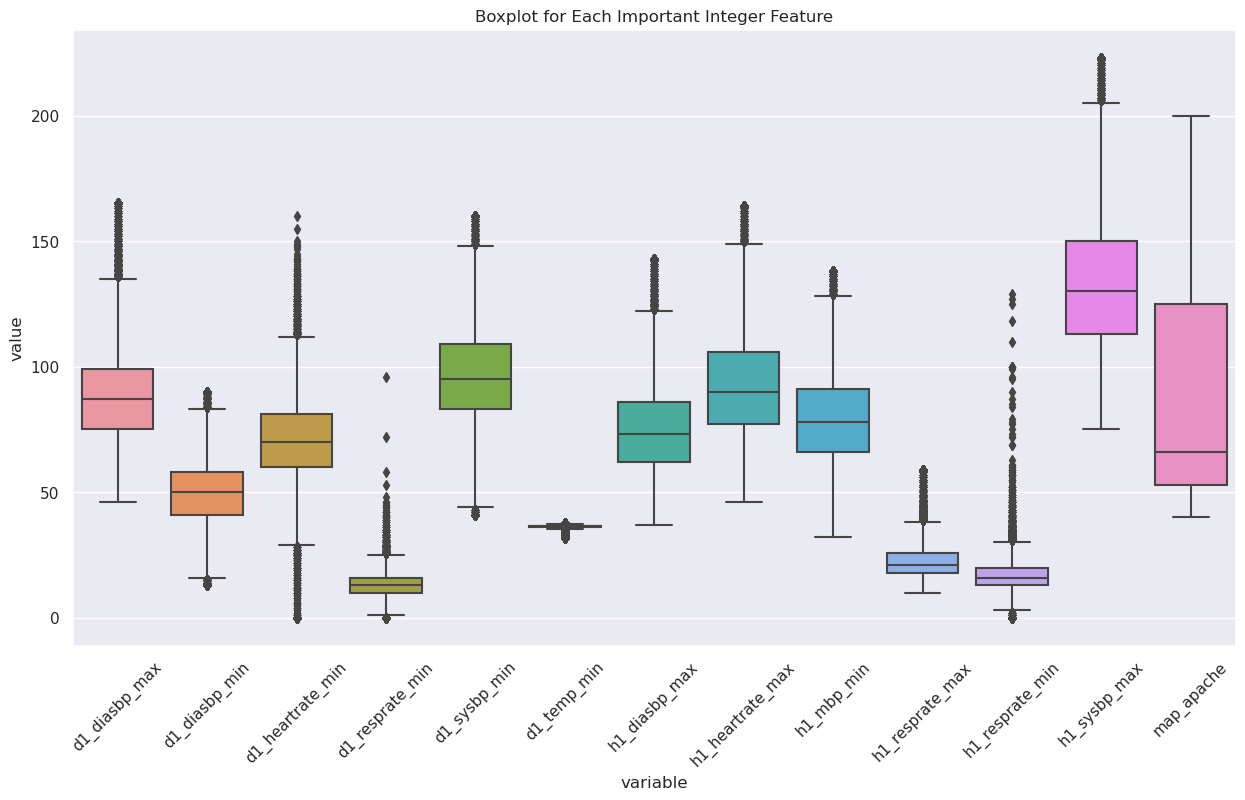

In [56]:
sns.set_theme(style="darkgrid")
final_integer_vars_pd = final_integer_vars.toPandas()
df_plot = final_integer_vars_pd.melt()
df_plot
plt.figure(figsize=(15,8))
sns.boxplot(x='variable', y='value', data=df_plot).set(title='Boxplot for Each Important Integer Feature')
plt.xticks(rotation=45)
plt.show()

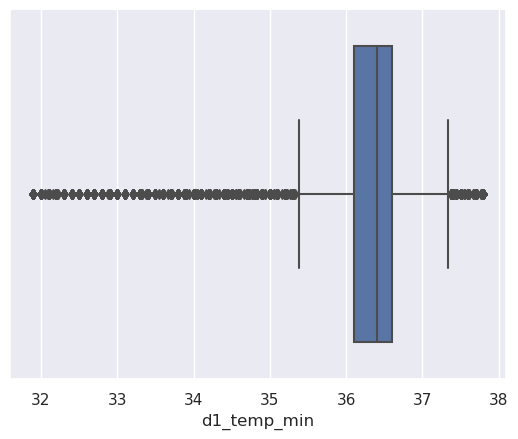

In [57]:
sns.set_theme(style="darkgrid")
sns.boxplot(x='d1_temp_min', data=final_integer_vars_pd)
plt.show()

In [58]:
final_vars_with_hos_death = df_2.select('GCS_buckets',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_min',
 'd1_resprate_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_heartrate_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_sysbp_max',
 'intubated_apache',
 'map_apache',
 'ventilated_apache',
 'hospital_death')

final_vars_with_hos_death.take(2)

[Row(GCS_buckets=2.0, d1_diasbp_max=68, d1_diasbp_min=37, d1_heartrate_min=72, d1_resprate_min=10, d1_sysbp_max=131, d1_sysbp_min=73, d1_temp_min=37.2, h1_diasbp_max=68, h1_heartrate_max=119, h1_mbp_min=85, h1_resprate_max=26, h1_resprate_min=18, h1_sysbp_max=131, intubated_apache=False, map_apache=40, ventilated_apache=False, hospital_death=False),
 Row(GCS_buckets=0.0, d1_diasbp_max=95, d1_diasbp_min=31, d1_heartrate_min=72, d1_resprate_min=12, d1_sysbp_max=159, d1_sysbp_min=67, d1_temp_min=35.1, h1_diasbp_max=61, h1_heartrate_max=114, h1_mbp_min=57, h1_resprate_max=31, h1_resprate_min=28, h1_sysbp_max=95, intubated_apache=False, map_apache=46, ventilated_apache=True, hospital_death=False)]

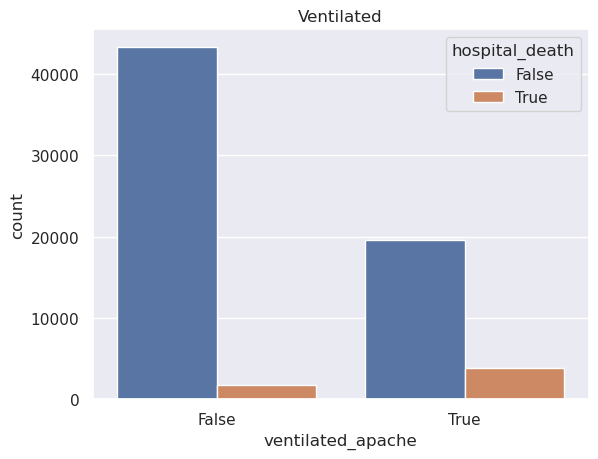

In [59]:
final_vars_with_hos_death_pd = final_vars_with_hos_death.toPandas()

sns.set_theme(style="darkgrid")
sns.countplot(x= 'ventilated_apache', hue='hospital_death', data=final_vars_with_hos_death_pd).set(title='Ventilated')
plt.show()

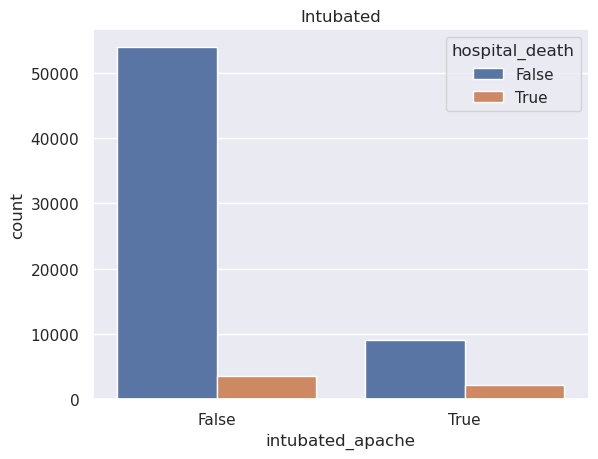

In [60]:
final_vars_with_hos_death_pd = final_vars_with_hos_death.toPandas()

sns.set_theme(style="darkgrid")
sns.countplot(x= 'intubated_apache', hue='hospital_death', data=final_vars_with_hos_death_pd).set(title='Intubated')
plt.show()

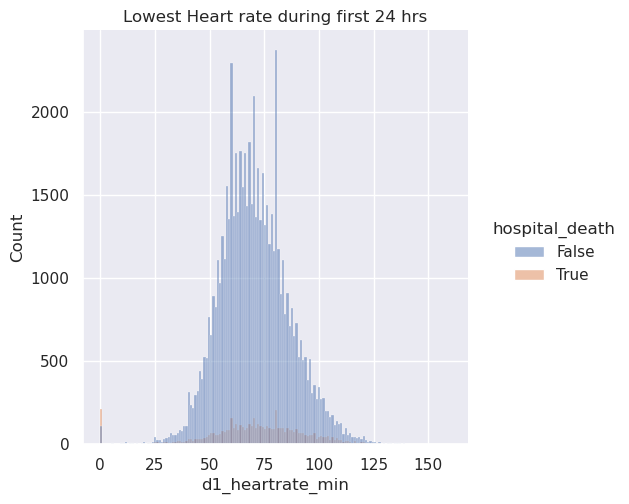

In [61]:
sns.set_theme(style="darkgrid")
sns.displot(x='d1_heartrate_min', hue='hospital_death', data=final_vars_with_hos_death_pd).set(title='Lowest Heart rate during first 24 hrs')
plt.show()

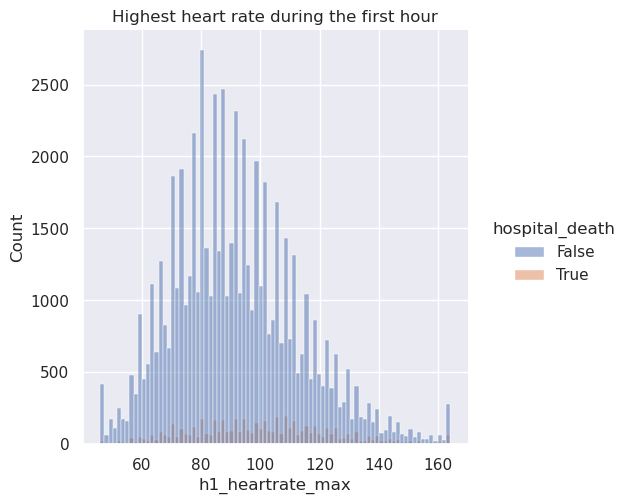

In [62]:
sns.set_theme(style="darkgrid")
sns.displot(x='h1_heartrate_max', hue='hospital_death', data=final_vars_with_hos_death_pd).set(title='Highest heart rate during the first hour')
plt.show()

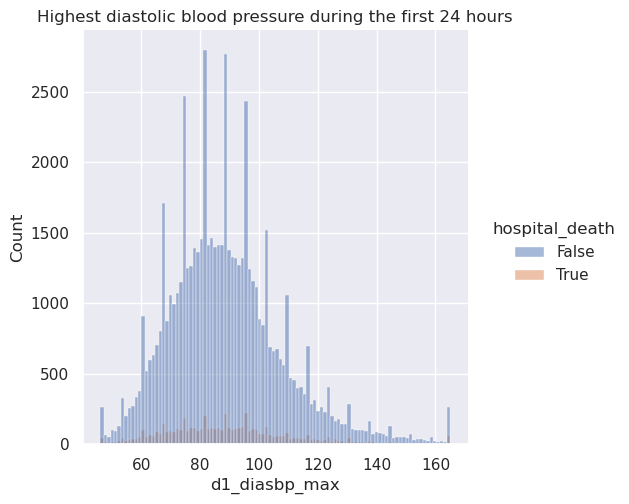

In [63]:
sns.set_theme(style="darkgrid")
sns.displot(x='d1_diasbp_max', hue='hospital_death', data=final_vars_with_hos_death_pd).set(title='Highest diastolic blood pressure during the first 24 hours')
plt.show()

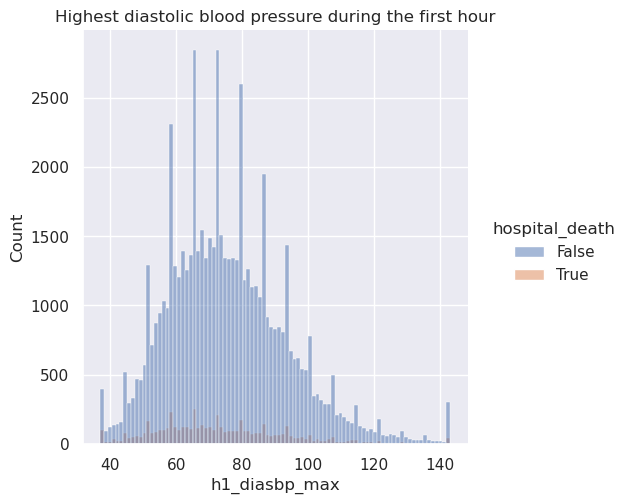

In [64]:
sns.set_theme(style="darkgrid")
sns.displot(x='h1_diasbp_max', hue='hospital_death', data=final_vars_with_hos_death_pd).set(title='Highest diastolic blood pressure during the first hour')
plt.show()

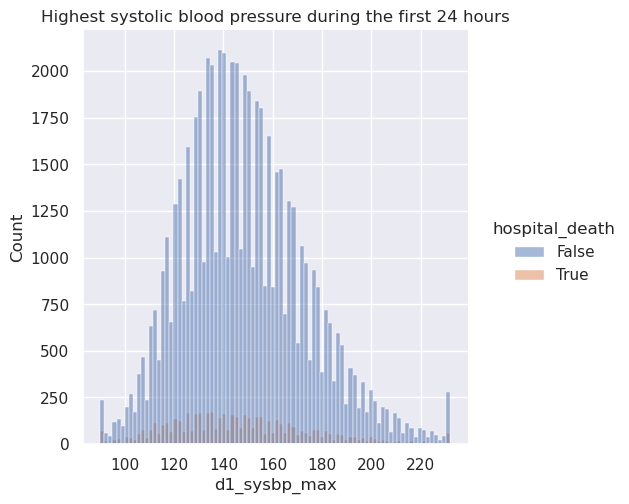

In [65]:
sns.set_theme(style="darkgrid")
sns.displot(x='d1_sysbp_max', hue='hospital_death', data=final_vars_with_hos_death_pd).set(title='Highest systolic blood pressure during the first 24 hours')
plt.show()

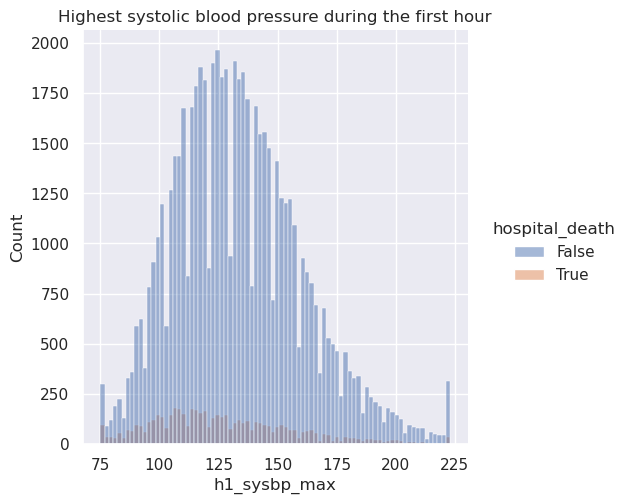

In [66]:
sns.set_theme(style="darkgrid")
sns.displot(x='h1_sysbp_max', hue='hospital_death', data=final_vars_with_hos_death_pd).set(title='Highest systolic blood pressure during the first hour')
plt.show()

### Addressing our Imbalanced Data Set

In [67]:
# Outcome variable distribution
df.groupBy("hospital_death").count().show()

+--------------+-----+
|hospital_death|count|
+--------------+-----+
|          true| 5603|
|         false|62991|
+--------------+-----+



In [68]:
from pyspark.sql.functions import col

def downsample(df, target, positive_label, negative_label):
    """
    df              spark dataframe
    target          str, target variable
    positive_label  int, value of positive label
    negative_label  int, value of negative label
    
    """

    major_df = df.filter(col(target) == positive_label)
    minor_df = df.filter(col(target) == negative_label)
    major_count = major_df.count()
    minor_count = minor_df.count() 
    if major_count > minor_count:
        ratio = minor_count/major_count
        sampled_df = major_df.sample(True, ratio,seed=seed)
        df_b = sampled_df.unionAll(minor_df)
    elif minor_count > major_count:
        ratio = major_count/minor_count
        sampled_df = minor_df.sample(True, ratio,seed=seed)
        df_b = sampled_df.unionAll(major_df)
    else:
        
        df_b = df
    return df_b

## Model Building and Evaluation

### Logistic Regression - Benchmark model

In [69]:
df_subset = df_2.select('GCS_buckets',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_min',
 'd1_resprate_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_heartrate_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_sysbp_max',
 'intubated_apache',
 'map_apache',
 'ventilated_apache',
 'hospital_death')

df_subset = df_subset.withColumn('hospital_death', F.when(df_subset.hospital_death == False, 0).otherwise(1))

df_subset.count()

68594

In [70]:
# define training and testing data to be used for all models
training_fraction = [0.8,0.2]
seed = 314
train_data, test_data = df_subset.randomSplit(training_fraction, seed=seed)

target = 'hospital_death'
positive_label = 1
negative_label = 0

# Call your downsample function here, and show the count by label to confirm

df_subset_balanced = downsample(train_data,target,positive_label,negative_label)

In [71]:
from pyspark.ml.classification import LogisticRegression

va = VectorAssembler(inputCols=[c for c in df_subset_balanced.columns if c not in {'hospital_death'}], outputCol="features")  
sc = StandardScaler(inputCol="features", outputCol="scaledFeatures")
lr = LogisticRegression(labelCol='hospital_death', featuresCol='scaledFeatures', fitIntercept=True)

# Fit the pipeline
pipeline = Pipeline(stages=[va, sc, lr])
log_model = pipeline.fit(df_subset_balanced)

In [72]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

log_pred = log_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol='hospital_death', rawPredictionCol="prediction", metricName='areaUnderROC')
print('Test Area under ROC curve', evaluator.evaluate(log_pred))

evaluator_2 = MulticlassClassificationEvaluator(labelCol='hospital_death', predictionCol="prediction")
print('Test Accuracy', evaluator_2.evaluate(log_pred,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7279123721169074
Test Accuracy 0.7428383993002405


In [73]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = log_pred.select(['prediction','hospital_death']).withColumn('label', F.col('hospital_death').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[9383. 3198.]
 [ 330.  808.]]


In [74]:
print('False Positive Rate', metrics.falsePositiveRate(1.0))
print('Recall', metrics.recall(1.0))
print('Precision', metrics.precision(1.0))

False Positive Rate 0.2541928304586281
Recall 0.7100175746924429
Precision 0.2016974538192711


### Optimizing our Logistic Regression with Parameter Tuning and Cross Validation

In [75]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 0.01, 0.5, 2.0 ]) \
    .addGrid(lr.maxIter, [5, 10, 100, 200]) \
    .build()

# Treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='hospital_death', rawPredictionCol="prediction"),
                          numFolds=5)

# Run cross-validation, and choose the best set of parameters. Print the training time.
import time
t0 = time.time()
cvModel = crossval.setParallelism(4).fit(df_subset_balanced) # train 4 models in parallel

print("train time:", time.time() - t0)

train time: 158.34156465530396


In [76]:
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='LogisticRegression_872720c45542', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_872720c45542', name='maxIter', doc='max number of iterations (>= 0).'): 200}


In [77]:
cv_log_pred = cvModel.transform(test_data)

print('Test Area under ROC curve', evaluator.evaluate(cv_log_pred))
print('Test Accuracy', evaluator_2.evaluate(cv_log_pred ,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7309747423689221
Test Accuracy 0.7477221371820103


In [78]:
preds_and_labels = cv_log_pred.select(['prediction','hospital_death']).withColumn('label', F.col('hospital_death').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[9449. 3132.]
 [ 329.  809.]]


In [79]:
print('False Positive Rate', metrics.falsePositiveRate(1.0))
print('Recall', metrics.recall(1.0))
print('Precision', metrics.precision(1.0))

False Positive Rate 0.24894682457674272
Recall 0.710896309314587
Precision 0.20527784826186246


### Gradient Boosting

In [80]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol='hospital_death', featuresCol='scaledFeatures', maxIter=10)

pipeline = Pipeline(stages=[va, sc, gbt])

gbt_model = pipeline.fit(df_subset_balanced)

In [81]:
gbt_pred = gbt_model.transform(test_data)

print('Test Area under ROC curve', evaluator.evaluate(gbt_pred))
print('Test Accuracy', evaluator_2.evaluate(gbt_pred ,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7350902181980276
Test Accuracy 0.7479408120125374


In [82]:
preds_and_labels = gbt_pred.select(['prediction','hospital_death']).withColumn('label', F.col('hospital_death').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[9442. 3139.]
 [ 319.  819.]]


In [83]:
print('False Positive Rate', metrics.falsePositiveRate(1.0))
print('Recall', metrics.recall(1.0))
print('Precision', metrics.precision(1.0))

False Positive Rate 0.24950321913997298
Recall 0.7196836555360281
Precision 0.20692268822637697


##### Since decision trees are immune to multicollinearity, let's see how the tree performs with all of the features

In [84]:
df_2 = df_2.withColumn('hospital_death', F.when(df_2.hospital_death == False, 0).otherwise(1))

# define training and testing data to be used for all subset models
training_fraction = [0.8,0.2]
seed = 314
train_data_all_vars, test_data_all_vars = df_2.randomSplit(training_fraction, seed=seed)

target = 'hospital_death'
positive_label = 1
negative_label = 0

# Call your downsample function here, and show the count by label to confirm

df_all_vars_balanced = downsample(train_data_all_vars,target,positive_label,negative_label)

gbt = GBTClassifier(labelCol='hospital_death', featuresCol='scaledFeatures', maxIter=10)

pipeline = Pipeline(stages=[va, sc, gbt])

gbt_model = pipeline.fit(df_all_vars_balanced)

In [85]:
gbt_pred_2 = gbt_model.transform(test_data_all_vars)

print('Test Area under ROC curve', evaluator.evaluate(gbt_pred_2))
print('Test Accuracy', evaluator_2.evaluate(gbt_pred_2 ,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.736826296565917
Test Accuracy 0.7416721335374299


In [86]:
preds_and_labels = gbt_pred_2.select(['prediction','hospital_death']).withColumn('label', F.col('hospital_death').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[9365. 3246.]
 [ 298.  810.]]


In [87]:
print('False Positive Rate', metrics.falsePositiveRate(1.0))
print('Recall', metrics.recall(1.0))
print('Precision', metrics.precision(1.0))

False Positive Rate 0.25739433827610814
Recall 0.7310469314079422
Precision 0.1997041420118343


##### We are going to continue to move forward with the simpler model with fewer features

### Optimizing the parameters of our Gradient Boosted Trees Implementation

##### Due to runtime (and we can run the trees in parallel), we are going to break the pararm grid into parts 

#### First, testing different max depths

In [88]:
# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [2, 5, 10]) \
    .build()

# Treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='hospital_death', rawPredictionCol="prediction"),
                          numFolds=5)

# Run cross-validation, and choose the best set of parameters. Print the training time.
import time
t0 = time.time()
cvModel = crossval.fit(df_subset_balanced)

print("train time:", time.time() - t0)

train time: 125.16430807113647


In [89]:
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='GBTClassifier_5ba3ff3f7130', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5}


In [90]:
cv_gbt_pred = cvModel.transform(test_data)

print('Test Area under ROC curve', evaluator.evaluate(cv_gbt_pred))
print('Test Accuracy', evaluator_2.evaluate(cv_gbt_pred ,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7350902181980276
Test Accuracy 0.7479408120125374


#### Next, testing different max bins

In [91]:
# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxBins, [10, 20, 40]) \
    .build()

# Treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='hospital_death', rawPredictionCol="prediction"),
                          numFolds=5)

# Run cross-validation, and choose the best set of parameters. Print the training time.
import time
t0 = time.time()
cvModel = crossval.fit(df_subset_balanced)

print("train time:", time.time() - t0)

train time: 97.3459837436676


In [92]:
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='GBTClassifier_5ba3ff3f7130', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 10}


In [93]:
cv_gbt_pred = cvModel.transform(test_data)

print('Test Area under ROC curve', evaluator.evaluate(cv_gbt_pred))
print('Test Accuracy', evaluator_2.evaluate(cv_gbt_pred ,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7344918810117469
Test Accuracy 0.747576353961659


#### Next, testing different max iterations

In [94]:
# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [5, 10, 20]) \
    .build()

# Treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='hospital_death', rawPredictionCol="prediction"),
                          numFolds=5)

# Run cross-validation, and choose the best set of parameters. Print the training time.
import time
t0 = time.time()
cvModel = crossval.fit(df_subset_balanced)

print("train time:", time.time() - t0)

train time: 109.27358627319336


In [95]:
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='GBTClassifier_5ba3ff3f7130', name='maxIter', doc='max number of iterations (>= 0).'): 20}


In [96]:
cv_gbt_pred = cvModel.transform(test_data)

print('Test Area under ROC curve', evaluator.evaluate(cv_gbt_pred))
print('Test Accuracy', evaluator_2.evaluate(cv_gbt_pred ,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7438068800988575
Test Accuracy 0.7463371965886726


#### We are going to continue with our GBT with max depth at 5, max bins at 10, and max iterations at 20

In [97]:
gbt = GBTClassifier(labelCol='hospital_death', featuresCol='scaledFeatures', maxDepth=5, maxBins=10, maxIter=20)

pipeline = Pipeline(stages=[va, sc, gbt])

gbt_model = pipeline.fit(df_subset_balanced)

gbt_pred_final = gbt_model.transform(test_data)

print('Test Area under ROC curve', evaluator.evaluate(gbt_pred_final))
print('Test Accuracy', evaluator_2.evaluate(gbt_pred_final ,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7392873791189856
Test Accuracy 0.747576353961659


#### Confusion Matrix

In [98]:
preds_and_labels = gbt_pred_final.select(['prediction','hospital_death']).withColumn('label', F.col('hospital_death').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[9426. 3155.]
 [ 308.  830.]]


#### FPR, Recall, Precision

In [99]:
print('False Positive Rate:', metrics.falsePositiveRate(1.0))
print('Recall:', metrics.recall(1.0))
print('Precision:', metrics.precision(1.0))

False Positive Rate: 0.2507749781416422
Recall: 0.7293497363796133
Precision: 0.20828105395232122


### Random Forest with Important Features (per PCA, Multicollinearity Checks)

In [117]:
# Importing necessary ML libraries and packages
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

va = VectorAssembler(inputCols=[c for c in df_subset_balanced.columns if c not in {'hospital_death'}], outputCol="features")  
sc = StandardScaler(inputCol="features", outputCol="scaledFeatures")
rf = RandomForestClassifier(labelCol="hospital_death", featuresCol="scaledFeatures")

pipeline = Pipeline(stages=[va, sc, rf])
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 64, stop = 128, num = 32)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 15, num = 5)]) \
    .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='hospital_death', rawPredictionCol="prediction"),
                          numFolds=3)

import time
t0 = time.time()
cvModel = crossval.setParallelism(4).fit(df_subset_balanced)

print("train time:", time.time() - t0)

train time: 5749.895005226135


In [118]:
rf_pred_final = cvModel.transform(test_data)

#### Feature Importance Plot

In [119]:
feature_importances = cvModel.bestModel.stages[-1].featureImportances
feature_importances = np.delete(feature_importances.toArray(), 16)
feature_importances

array([0.0897723 , 0.04454301, 0.06740182, 0.05274793, 0.04445777,
       0.04314485, 0.12163924, 0.07465531, 0.03798133, 0.05022401,
       0.04472109, 0.05603872, 0.05575693, 0.04156113, 0.02046542,
       0.0576495 ])

In [120]:
df_subset_balanced.columns

['GCS_buckets',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_min',
 'd1_resprate_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_heartrate_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_sysbp_max',
 'intubated_apache',
 'map_apache',
 'ventilated_apache',
 'hospital_death']

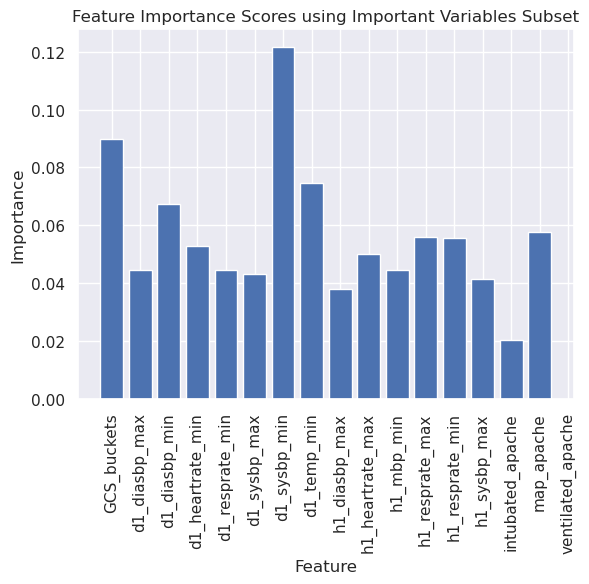

<Figure size 1500x800 with 0 Axes>

In [121]:
x_values = list(range(len(feature_importances)))
plt.bar(x_values, feature_importances, orientation='vertical')
plt.xticks(range(17), [c for c in df_subset_balanced.columns if c not in {'hospital_death'}], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importance Scores using Important Variables Subset')
plt.figure(figsize=(15, 8))
plt.show()

#### Classification Metrics

In [122]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

evaluator = BinaryClassificationEvaluator(labelCol='hospital_death', rawPredictionCol="prediction", metricName='areaUnderROC')
print('Test Area under ROC curve', evaluator.evaluate(rf_pred_final))

evaluator_2 = MulticlassClassificationEvaluator(labelCol='hospital_death', predictionCol="prediction")
print('Test Accuracy', evaluator_2.evaluate(rf_pred_final,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.7423342085989293
Test Accuracy 0.7443691231139296


In [123]:
#select only prediction and label columns
preds_and_labels = rf_pred_final.select(['prediction','hospital_death']).withColumn('label', F.col('hospital_death').cast(FloatType())).orderBy('prediction')

preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[9370. 3211.]
 [ 296.  842.]]


In [124]:
print('False Positive Rate:', metrics.falsePositiveRate(1.0))
print('Recall:', metrics.recall(1.0))
print('Precision:', metrics.precision(1.0))

False Positive Rate: 0.2552261346474843
Recall: 0.7398945518453427
Precision: 0.20774734764372071


### K Means Classifier

In [125]:
dfb = va.transform(df_2)
dfb

DataFrame[age: int, bmi: double, elective_surgery: boolean, height: double, pre_icu_los_days: double, weight: double, apache_post_operative: boolean, arf_apache: boolean, gcs_unable_apache: int, heart_rate_apache: int, intubated_apache: boolean, map_apache: int, resprate_apache: double, temp_apache: double, ventilated_apache: boolean, d1_diasbp_max: int, d1_diasbp_min: int, d1_heartrate_max: int, d1_heartrate_min: int, d1_mbp_max: int, d1_mbp_min: int, d1_resprate_max: int, d1_resprate_min: int, d1_spo2_max: int, d1_spo2_min: int, d1_sysbp_max: int, d1_sysbp_min: int, d1_temp_max: double, d1_temp_min: double, h1_diasbp_max: int, h1_diasbp_min: int, h1_heartrate_max: int, h1_heartrate_min: int, h1_mbp_max: int, h1_mbp_min: int, h1_resprate_max: int, h1_resprate_min: int, h1_spo2_max: int, h1_spo2_min: int, h1_sysbp_max: int, h1_sysbp_min: int, d1_glucose_max: int, d1_glucose_min: int, aids: boolean, cirrhosis: boolean, diabetes_mellitus: boolean, hepatic_failure: boolean, immunosuppress

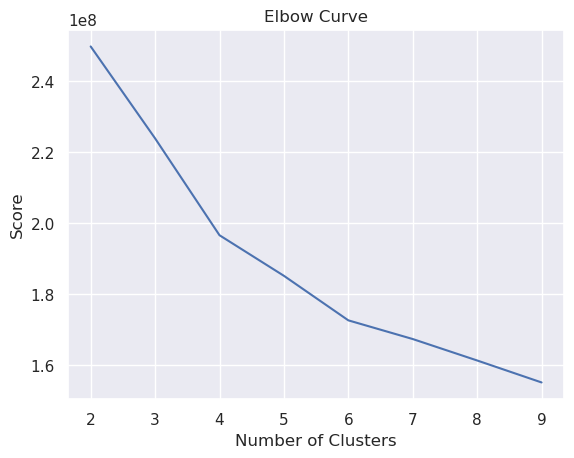

In [126]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
import pandas as pd

cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(314).setFeaturesCol('features')
    model = kmeans.fit(dfb)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [127]:
train_split = [0.8,0.2]
seed = 314
train, test = df_subset_balanced.randomSplit(train_split, seed=seed)

va = VectorAssembler(inputCols=[c for c in df_subset_balanced.columns if c not in {'hospital_death'}], outputCol="features")  
sc = StandardScaler(inputCol="features", outputCol="scaledFeatures")
km = KMeans().setK(7).setSeed(314).setFeaturesCol('scaledFeatures')

# Fit the pipeline
pipeline = Pipeline(stages=[va, sc, km])
km_model = pipeline.fit(train)

In [128]:
km_pred = km_model.transform(test)

In [129]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(km_pred)
print("Silhouette with squared euclidean distance = " + str(silhouette))

print("Cluster Centers: ")
centers = km_model.stages[2].clusterCenters()
print(centers)

Silhouette with squared euclidean distance = 0.010594713689364271
Cluster Centers: 
[array([2.05456257e+00, 4.81792082e+00, 4.29407622e+00, 3.45012010e+00,
       2.44529348e+00, 6.21230769e+00, 5.18736343e+00, 3.34564700e+01,
       4.52095326e+00, 3.95447339e+00, 4.86508179e+00, 2.82976469e+00,
       2.68824803e+00, 5.40445953e+00, 2.56566197e-02, 2.69352459e+00,
       2.94938185e-01]), array([ 0.48525055,  5.54087138,  3.26786757,  3.14417   ,  1.92347737,
        6.66454854,  3.95737111, 32.48274292,  5.25212751,  4.43806396,
        4.41983936,  3.04482827,  2.52544975,  5.7690151 ,  1.22240154,
        2.86952501,  1.83038168]), array([ 2.1613169 ,  3.93996602,  3.19549945,  3.14498855,  2.05465483,
        5.123287  ,  4.08594215, 33.32316407,  3.40897294,  3.65311363,
        3.55628873,  2.51332071,  2.33151759,  4.18902649,  0.        ,
        1.49876092,  0.20679833]), array([ 1.2393413 ,  4.60506477,  2.94315546,  3.92237175,  3.03927828,
        5.68943914,  3.64096318,

In [130]:
from pyspark.sql.types import DoubleType

km_pred = km_pred.withColumn("prediction", km_pred["prediction"].cast(DoubleType()))

In [131]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='hospital_death', rawPredictionCol="prediction", metricName='areaUnderROC')
print('Test Area under ROC curve', evaluator.evaluate(km_pred))

evaluator_2 = MulticlassClassificationEvaluator(labelCol='hospital_death', predictionCol="prediction")
print('Test Accuracy', evaluator_2.evaluate(km_pred,{evaluator_2.metricName: "accuracy"}))

Test Area under ROC curve 0.6555844633659204
Test Accuracy 0.21764032073310424


In [132]:
preds_and_labels = km_pred.select(['prediction','hospital_death']).withColumn('label', F.col('hospital_death').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[270.  43.]
 [ 67. 110.]]


In [133]:
print('False Positive Rate', metrics.falsePositiveRate(1.0))
print('Recall', metrics.recall(1.0))
print('Precision', metrics.precision(1.0))

False Positive Rate 0.04746136865342163
Recall 0.13095238095238096
Precision 0.7189542483660131
